## Load the metadata

The metadata pre-processed in notebook 1 contains the id's of the 3D-models that will be downloaded. 

In [1]:
import pandas as pd
import os

# reload the cleaned-up data
metadata_df = pd.read_csv(os.path.join('data', 'metadata.csv'), index_col=False)
print('There are {} 3D-models in the dataset.'.format(metadata_df.shape[0]))

There are 971 3D-models in the dataset.


## Downloading 3D models
I obtained 3D-models from the [Sketchfab website](https://sketchfab.com/3d-models/categories/cultural-heritage-history?date=week&features=downloadable&licenses=322a749bcfa841b29dff1e8a1bb74b0b&licenses=b9ddc40b93e34cdca1fc152f39b9f375&licenses=72360ff1740d419791934298b8b6d270&licenses=bbfe3f7dbcdd4122b966b85b9786a989&licenses=2628dbe5140a4e9592126c8df566c0b7&licenses=34b725081a6a4184957efaec2cb84ed3&licenses=7c23a1ba438d4306920229c12afcb5f9&licenses=783b685da9bf457d81e829fa283f3567&licenses=5b54cf13b1a4422ca439696eb152070d&sort_by=-likeCount). Sketchfab provides an [API](https://docs.sketchfab.com/data-api/v3/index.html#!/models/get_v3_models_uid_download) for querying and downloading 3D-models. I contacted Sketchfab to check if it would be alright to download a large number of 3D-models. They have been very supportive to my idea and I managed to use the API to download all the metadata and a few 3D-models. 
The API requires a Sketchfab account and a key. The key is stored in the file `client_credentials.json` (not included in the submission). Please note that:
* 3D-models are large files. The project should require an estimated 20 GB of data, for the downloaded files alone. I setup a virtual storage with 50 GB to hold the data for this project. Github recommends keeping projects under 5 GB. Therefore I will not be able to upload the 3D-models as such to the capstone repository, but only the pre-processed files. 
* the Sketchfab API has various download rate restrictions (per day, per hour, per minute), so that the download process has to be extended over a period of several days.

In [2]:
import json
import requests
import os
import time

# load credentials stored in local file
with open('client_credentials.json') as file:
    client_credentials = json.load(file)
API_TOKEN = client_credentials['api_token'] # Token from Sketchfab account

DOWNLOAD_DIR = '/mnt/Disk2/downloaded_models' # Folder to store the downloaded files
DOWNLOAD_DELAY = 20 # seconds, 200 / hour API rate limit
DOWNLOAD_ENDPOINT = 'https://api.sketchfab.com/v3/models/{}/download' # API endpoint

# HTTP request headers
headers = {'Authorization': 'Token {}'.format(API_TOKEN)} # Authorization method used
headers.update({'Content-Type': 'application/json'}) # http content type of the request

def download_data(uid):
    """
    Downloads a 3D-model from Sketchfab, saves it to a zipped file.
    @param: uid unique id of the model
    @raises: RequestException, e.g. API limit exceeded
    """
    # get the download url of the model
    # this url is only valid for a few minutes
    r = requests.get(
        DOWNLOAD_ENDPOINT.format(model_uid),
        headers = headers
    )
    r.raise_for_status() # throw exception if request status is not OK
    model_link = json.loads(r.text)
    url = model_link['gltf']['url'] # download url of the model

    # download the 3D-model, save it to file
    r = requests.get(url)
    with open(filename,'wb') as output_file:
        output_file.write(r.content)
            

try:
    # loop through the metadata table and download each 3D-model
    total = len(metadata_df)
    counter = 1
    for model_uid in metadata_df['id']:
        filename = os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)) # file to save the 3D-model
        if os.path.isfile(filename): # check that the file hasn't been downloaded already
            print('File {} already exists'.format(filename))
        else:
            print('Downloading model {} ({}/{})'.format(model_uid, counter, total))
            download_data(model_uid) # download and save the 3D-model
            time.sleep(DOWNLOAD_DELAY) # don't hit the API too hard
        counter += 1

# Downloads may fail, typically when API limit exceeded
except requests.exceptions.RequestException:
    print('Download failed for 3D-model: {}'.format(model_uid))


File /mnt/Disk2/downloaded_models/a049baa005da476bb7ffe1df5e6b4f78.zip already exists
File /mnt/Disk2/downloaded_models/836630c9eb6344878f5b3e72aaa37f8b.zip already exists
File /mnt/Disk2/downloaded_models/77d11d8ec01e424e829b9914c388b0a1.zip already exists
File /mnt/Disk2/downloaded_models/c9c8bce4d27a4fef88622682bf2741b1.zip already exists
File /mnt/Disk2/downloaded_models/991d3fd5aab643609819ade2a1df1eb2.zip already exists
File /mnt/Disk2/downloaded_models/89fdc50c378c4b8ea4348f673318a179.zip already exists
File /mnt/Disk2/downloaded_models/f5a96c73c0eb49a1b787ae258eb02891.zip already exists
File /mnt/Disk2/downloaded_models/ab333c7e6d0f41cbafbbc36b634488a5.zip already exists
File /mnt/Disk2/downloaded_models/fbe2776af5f44d83bb32e6633d151178.zip already exists
File /mnt/Disk2/downloaded_models/72aba513c29241a3a0843a14dba596a5.zip already exists
File /mnt/Disk2/downloaded_models/7bbe7a566f074896b9cffea1e353275a.zip already exists
File /mnt/Disk2/downloaded_models/036abe36af224e588d3f

## Pre-processing 3D-models

The files containing the 3D-models have to be unzipped to a temporary folder. 3D-Models provided by the API are in Graphics Language Transmission Format (glTF). I implemented a reader for this kind of files using the open source [pygltflib library](https://pypi.org/project/pygltflib/). This library is __not included in the course environment, but can be installed using pip__. 

<img src="fig/point_cloud_texture.png">

_Figure 3: A Greek jug (A), its 3D point cloud (B), its texture image (C)._

After extracting the texture and the point cloud data from each 3D-model,
* I downsampled texture data to the size expected by the data extraction model, i.e. 299x299 pixels RGB, and I applied standardization to the texture images.
* I downsampled point cloud data so that the number of vertices is the number computed in the EDA in notebook 1, i.e. 37838 vertices.

I saved the downsampled data of each 3D-model in an .npz file containing "point cloud" data, and a second .npz file for texture images (fig. 3). The classifiers I implemented use either point cloud or texture data for input, so organizing these data separately at this stage will be beneficial later on. 

### Implement a function to decode GLTF files

In [2]:
import zipfile
from pygltflib import GLTF2, BufferFormat
import struct
import numpy as np
import warnings
warnings.filterwarnings("ignore") # the gltf loader raises some unecessary warning

DOWNLOAD_DIR = '/mnt/Disk2/downloaded_models' # Folder where the downloaded files are stored
TEMP_DIR = '/mnt/Disk2/temp' # Folder to temporarily extract the zipped files

def extract_gltf(model_uid):
    """
    Extracts the point cloud data from a gltf file as a numpy array.
    The returned array contains the 3D coordinates of all points in the point cloud.
    @param model_uid, string, id of a model
    @returns a numpy array of 3D coordinates
    """
    try:
        # create a temporary folder to extract this file
        unzip_dir = os.path.join(TEMP_DIR, model_uid)
        os.mkdir(unzip_dir)

        # unzip the downloaded 3D-model
        filename_zipped = os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)) # zip file containing the the 3D-model
        with zipfile.ZipFile(filename_zipped, 'r') as zip_file:
            zip_file.extractall(unzip_dir)

        # After unzipping the file, open its "scene" data
        filename = os.path.join(unzip_dir, 'scene.gltf') # the "scene" file is always called scene.gltf
        gltf = GLTF2().load(filename)
        # load the binary data contained in the "scene.bin" into the gltf object
        gltf.convert_buffers(BufferFormat.DATAURI)

        # get the vertices for each primitive in each mesh
        vertices = []
        for mesh in gltf.meshes:
            for primitive in mesh.primitives:

                # get the binary data for this mesh primitive from the buffer
                accessor = gltf.accessors[primitive.attributes.POSITION]
                bufferView = gltf.bufferViews[accessor.bufferView]
                buffer = gltf.buffers[bufferView.buffer]
                data = gltf.decode_data_uri(buffer.uri)

                # pull each vertex from the binary buffer and convert it into a tuple of python floats
                for i in range(accessor.count):
                    index = bufferView.byteOffset + accessor.byteOffset + i*12  # the location in the buffer of this vertex
                    d = data[index:index+12]  # the vertex data
                    v = struct.unpack("<fff", d)   # convert from base64 to three floats
                    vertices.append(v)

        # convert the vertices to a numpy array
        vertices_np = np.array(vertices)
        return vertices_np
    
    finally:
        # whatever happens, delete the temporary folder
        os.remove(os.path.join(unzip_dir, 'scene.gltf'))
        os.remove(os.path.join(unzip_dir, 'scene.bin'))
        os.rmdir(unzip_dir)

### Subsample point clouds

In [3]:
MAX_VERTICES = metadata_df['vertexCount'].min() # the lowest vertex count of any model in the dataset
print('The 3D-models will be downsampled to {} vertices.'.format(MAX_VERTICES))

def subsample_model(vertices_np):
    """
    Reduces the number of vertices in the 3D-model.
    @param vertices_np np array as returned by extract_gltf()
    @returns np array with MAX_VERTICES vertices
    """
    return pd.DataFrame(vertices_np).sample(n=MAX_VERTICES, random_state=0).to_numpy()

The 3D-models will be downsampled to 37838 vertices.


In [4]:
# get a list of all 3D-models that have been downloaded
downloaded_uid = [model_uid for model_uid in metadata_df['id'] if os.path.isfile(os.path.join(DOWNLOAD_DIR, '{}.zip'.format(model_uid)))]

# read the point cloud and subsample the vertices to MAX_VERTICES
vertices = []
for model_uid in downloaded_uid:
    vertices_np = extract_gltf(model_uid)
    vertices_np = subsample_model(vertices_np)
    vertices.append(vertices_np)

### Rotate point clouds

In [5]:
import pandas as pd
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist

def rotate(point_cloud, rotation):
    """Rotates 3D model."""
    r = R.from_euler('xyz', rotation, degrees=True)
    point_cloud = r.apply(point_cloud)
    return point_cloud

# read rotations file
rotation_df = pd.read_csv(os.path.join('data', 'rotation.csv'), index_col=False)
rotated = [] # array of rotated point clouds
for i in range(len(downloaded_uid)): # loop through downloaded files
    # apply the rotation 
    rotation = list(rotation_df.loc[i, ['x', 'y', 'z']])
    rotated.append(rotate(vertices[i], rotation))

### Display some 3D-models

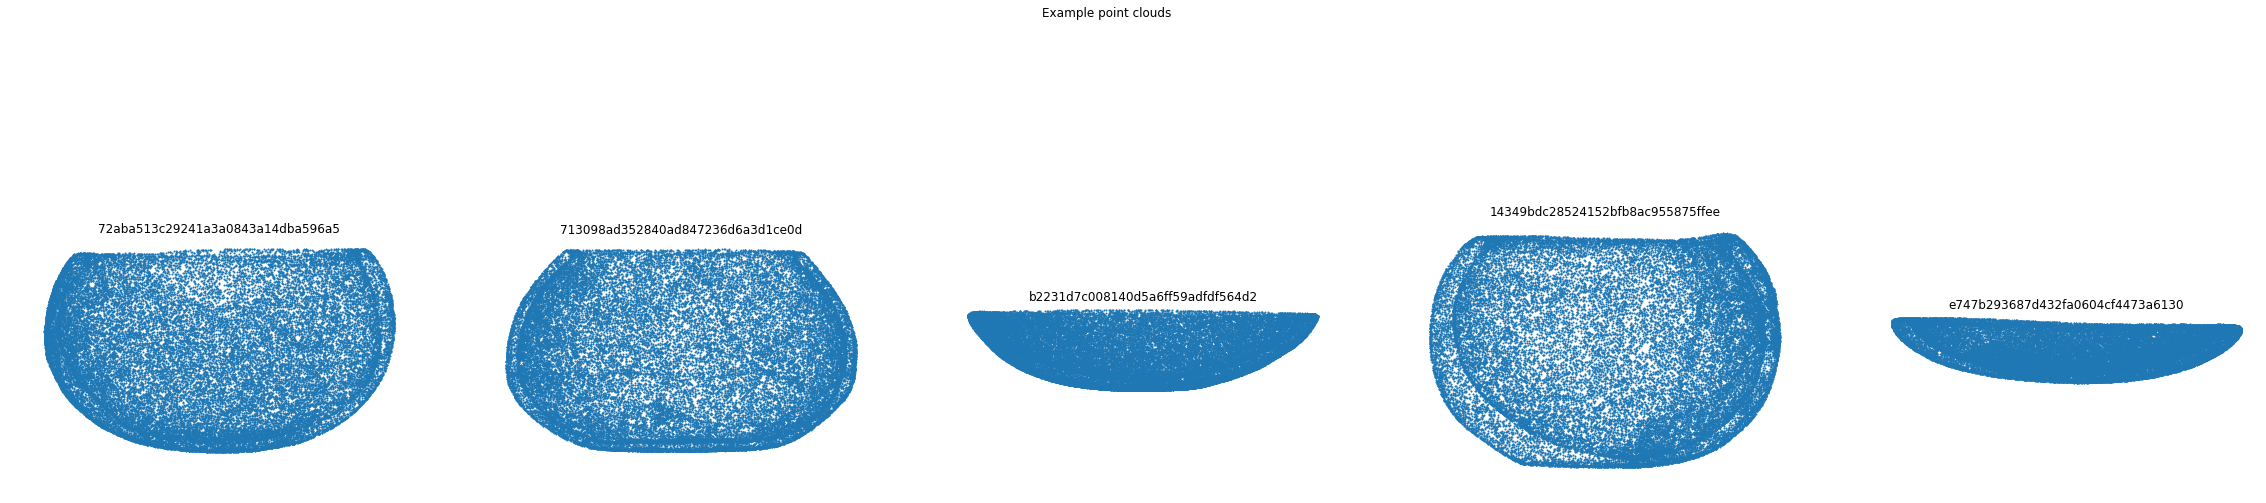

In [1120]:
%matplotlib inline
import matplotlib.pyplot as plt
import random 

def plot_model(point_cloud, title, ax):
    """
    Plots a point cloud along the x/y axis in orthogonal projection (i.e. without perspective).
    @param vertices np array of vertices (x,y,z) coordinates
    @param string model identifier (or other title)
    """
    dx = max(point_cloud[:,0]) - min(point_cloud[:,0])
    dy = max(point_cloud[:,1]) - min(point_cloud[:,1])
    prop = dy/dx
    ax.set_aspect(prop)
    # side
    ax.scatter(point_cloud[:,0], point_cloud[:,1], s=1)
    ax.set_title(title)
    ax.axis("off")

# select some 3D-models at random
num_models = 5
fig, ax = plt.subplots(1, num_models, figsize=(40, 10))
for i in range(num_models):
    idx = random.randrange(len(vertices))
    point_cloud = rotated[idx] # a numpy array of 3D coordinates
    model_uid = downloaded_uid[idx] #  a string identifying the model
    plot_model(point_cloud, model_uid, ax[i])
plt.suptitle('Example point clouds')
plt.show();

## Save
The 3D data has now been subsampled and rotated to its optimal position. The pre-processed 3D-data can now be saved to a compressed npz file.

In [6]:

NPZ_DIR = '/mnt/Disk2/npz_models' # Folder to store the 3D-models files

# save all extracted vertices to compressed file
np.savez_compressed(os.path.join('NPZ_DIR', 'point_clouds.npz'),
         model_uid = downloaded_uid,
         vertices = rotated
        )

testing

In [1059]:
idx = 138
point_cloud = vertices[idx] # a numpy array of 3D coordinates
model_uid = downloaded_uid[idx] #  a string identifying the model
point_cloud = rotate(point_cloud, [-90, 0, 0])
plot_model(point_cloud, model_uid)

IndexError: list index out of range

In [1091]:
len(vertices)

138

In [1092]:
id = rotated['model_uid'] == 'e4f4f433c23b4b028dbd01536759d522'

TypeError: list indices must be integers or slices, not str